# Import Libraries


In [5]:
!pip install torch==1.11
!pip install torchtext==0.12
!pip install torchvision==0.12

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 750.6 MB 11 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0
    Uninstalling torch-1.10.0:
      Successfully uninstalled torch-1.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.1+cu113 requires torch==1.12.1, but you have torch 1.11.0 which is incompatible.
torchtext 0.13.1 requires torch==1.12.1, but you have torch 1.11.0 which is incompatible.
torchaudio 0.12.1+cu113 requires torch==1.12.1, but you have torch 1.11.0 which is incompatible.


In [1]:
import torch
from torchvision import datasets
from torch.utils.data import DataLoader

from torchvision.transforms import Compose, ToTensor, Lambda, Resize, Normalize
from torchvision.transforms.functional import to_pil_image 

import matplotlib.pyplot as plt

CUDA_LAUNCH_BLOCKING=1

# Prepare Dataset

In [2]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.multiprocessing.set_start_method('spawn')

In [3]:
transform = Compose([
    Resize((64,64)),
    ToTensor(),
    Normalize(mean = [0.5125,0.4667,0.4110],
              std= [0.2621,0.2501,0.2453]),
    

])

In [4]:

train_flowers = datasets.Flowers102(
    "./sample_data/flowers_train", 
    split='train', 
    download=True, 
    transform=transform,
    # target_transform=Lambda(lambda y: torch.zeros(102, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

test_flowers = datasets.Flowers102(
    "./sample_data/flowers_test", 
    split='test',
    download=True, 
    transform=transform,
    # target_transform=Lambda(lambda y: torch.zeros(102, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

valid_flowers = datasets.Flowers102(
    "./sample_data/flowers_valid", 
    split='val', 
    download=True, 
    transform=transform,
    # target_transform=Lambda(lambda y: torch.zeros(102, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)),
    
)

In [5]:
device='cuda'

train_dataloader = DataLoader(test_flowers, batch_size=16, shuffle=True, generator=torch.Generator(device), num_workers=1)
test_dataloader = DataLoader(train_flowers, batch_size=16, shuffle=True, generator=torch.Generator(device), num_workers=1)

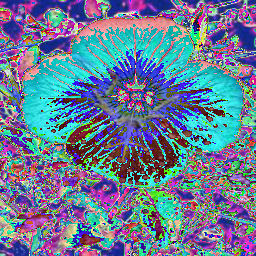

In [ ]:
to_pil_image(train_flowers[8][0])

# Count mean and std for whole data set for data Normaliation


In [21]:
# python code to calculate mean and std 
def batch_mean_and_sd(loader):
    
    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)

    for images, _ in loader:
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2,
                                  dim=[0, 2, 3])
        fst_moment = (cnt * fst_moment + sum_) / (
                      cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (
                            cnt + nb_pixels)
        cnt += nb_pixels

    mean, std = fst_moment, torch.sqrt(
      snd_moment - fst_moment ** 2)        
    return mean,std
  
mean, std = batch_mean_and_sd(train_dataloader)
print("mean and std: \n", mean, std)

mean and std: 
 tensor([-0.2922, -0.3627, -0.5117]) tensor([1.1160, 0.9576, 1.0744])


# Build model

In [6]:
# Load in relevant libraries, and alias where appropriate
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

num_classes = 102
learning_rate = 0.001
num_epochs = 20

# Device will determine whether to run the training on GPU or CPU.
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.batch_norm = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.batch_norm(x)
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (batch_norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [35]:
model = ConvNeuralNet(num_classes)

# Set Loss function with criterion
criterion = nn.CrossEntropyLoss()

# Set optimizer with optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  

total_step = len(train_dataloader)

In [38]:
# We use the pre-defined number of epochs to determine how many iterations to train the network on
for epoch in range(num_epochs):
	#Load in the data in batches using the train_loader object
    for i, (images, labels) in enumerate(train_dataloader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

RuntimeError: ignored